In [1]:
#pip3 install box2d-py
#!pip3 install gym[Box_2D]
import gym
import numpy as np
import torch
import torch.nn as nn
import random

env = gym.make("LunarLander-v2")

c:\Users\jessm\miniconda3\envs\model\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [2]:
#HYPERPARAMETERS
batch_size = 32
input_size = 8
layer1_size = 32
layer2_size = 32
output_size = 4
lr = 0.001
replay_size = 10000


device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using {} device'.format(device))

class network(nn.Module):
    def __init__(self, input_size, layer1_size, layer2_size, output_size):
        super(network,self).__init__()

        self.cnn = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.ReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.ReLU(),
            nn.Linear(layer2_size, output_size)
        )

    def forward(self,x):
        return self.cnn(x)

    def act(self,results):
        act = torch.argmax(results).item()
        return act

model = network(input_size, layer1_size, layer2_size, output_size)
target_model = network(input_size, layer1_size, layer2_size, output_size)
target_model.load_state_dict(model.state_dict())

Using cpu device


<All keys matched successfully>

In [22]:
loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

class Train:
    def __init__(self):
        self.alpha = 1
        self.gamma = 0.9
        self.epsilon = 1
        self.epsilon_decay = 0.9
        self.min_epsilon = 0.01

    def train(self,replay_memory,model,loss_fn,optimizer):
        x = []
        y = []
        if len(replay_memory) >= replay_size:
          batch = random.sample(replay_memory[-replay_size:],batch_size)
        elif len(replay_memory) >= batch_size:
          batch = random.sample(replay_memory,batch_size)
        else:
          batch = replay_memory
        #print('batch: ',batch)

        state_current = np.array([item[0] for item in batch])
        state_next = np.array([item[1] for item in batch])
        #print('state_current: ',state_current)
        #print('state_next: ',state_next)

        pred_current = model(torch.tensor(state_current))
        pred_next = target_model(torch.tensor(state_next))
        #print('pred_current: ',pred_current)
        #print('pred_next: ',pred_next)

        for i,(state,new_state,action,reward,done) in enumerate(batch):
            if not done:
                fq_max = reward + self.gamma*torch.max(pred_next[i]).item()
                #print('fq_max: {}, max: {}'.format(fq_max,torch.max(pred_next[i].item())))
            else:
                fq_max = reward

            q = pred_current[i]
            q[action] = fq_max
            #print('q: {}, q[action]: {}'.format(q,q[action]))

            x.append(state) #torch.tensor(state).to(device))
            y.append(q.detach().numpy()) #torch.tensor(pred_current).to(device))

        model.train()
        pred = model(torch.tensor(x))
        loss = loss_fn(pred,torch.tensor(y))
        #print('pred: {}, loss: {}'.format(pred,loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def test(self,episodes,target_model,loss_fn,test_reward):
        model.eval()

        with torch.no_grad():
            for ep in episodes:
                done = False
                score = 0
                state = env.reset()
                while not done:
                    a = target_model.act(target_model(torch.tensor(state)))

                    next_state, r, done, _ = env.step(a)

                    score += r

                    state = next_state
                #print('score: ',score)
                test_reward.append(score)

    
    def update(self,model, loss_fn, optimizer,train_rewards):
        replay_memory = []
        steps_update = 0
        episodes = 0

        while True:
            episodes += 1
            state = env.reset()
            score = 0
            done = False

            while not done:
                steps_update += 1
                #env.render()

                rand_num = np.random.random()
                if rand_num <= self.epsilon:
                    a = np.random.randint(4)
                    #print('random a: ',a)
                else:
                  with torch.no_grad():
                    results = model(torch.tensor(state))
                  a = model.act(results)
                  #print('model a: ',a)

                new_state, r, done, _ = env.step(a)
                #print('state: {}, new_state: {}, reward: {}'.format(state,new_state,r))

                score += r

                replay_memory.append([state,new_state,a,r,done])

                state = new_state

                if steps_update >= batch_size:
                  Train.train(self,replay_memory,model,loss_fn,optimizer)
                  #self.epsilon = max(self.epsilon_decay*self.epsilon,self.min_epsilon)
                
                if steps_update % 90 == 0:
                    target_model.load_state_dict(model.state_dict())

            train_rewards.append(score)
            print('score: {}'.format(score))
            if episodes % 20 == 0 and episodes >= 21:
              self.epsilon = max(self.epsilon_decay*self.epsilon,self.min_epsilon)
            if score >= 200:
              print('score over 200')
            if episodes % 100 == 0:
              print('EPISODE {}, Average score = {}, Epsilon: {}'.format(episodes,np.mean(train_rewards[-100:]),self.epsilon))
            if np.mean(train_rewards[-100:]) >= 200  or episodes == 1000:
              break
        #env.close()

In [4]:
import time

start = time.time()
print('start time: ',start)
train_rewards = []
NN = Train()
NN.update(model,loss_fn,optimizer,train_rewards)
end = time.time()
print('end time: {} \n time elapsed: {}'.format(end, end-start))

start time:  1656311559.625603
score: -189.97086100602328


C:\Users\jessm\AppData\Local\Temp\ipykernel_21056\248757721.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  pred = model(torch.tensor(x))


score: -105.01392733852556
score: -538.1872810717291
score: -125.8972718667947
score: -136.31792533072294
score: -190.1953626697088
score: -139.42474848516866
score: -127.90826896121027
score: -273.51696662496227
score: -118.53672435226042
score: -352.84409005676423
score: -104.39245035720218
score: -188.1287374287991
score: -102.2003347351068
score: -121.66081054222148
score: -133.93728792240535
score: -175.1808724916937
score: -51.57156605201757
score: -449.68740085153723
score: -70.16332883818325
score: -93.0717733099118
score: -108.31308509423839
score: -42.67152618114609
score: -86.81646852828501
score: -100.64823921532395
score: -145.12873137629987
score: -236.00920164379494
score: -92.80479297187439
score: -213.71323108870746
score: -129.16947637459785
score: -325.2443606983093
score: -92.08330194290889
score: -113.56457077695515
score: -107.6610950980143
score: -83.71737669923854
score: -101.29621069011982
score: -213.86924967734925
score: -431.16463154687875
score: -458.799196

KeyboardInterrupt: 

c:\Users\jessm\miniconda3\envs\model\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jessm\miniconda3\envs\model\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


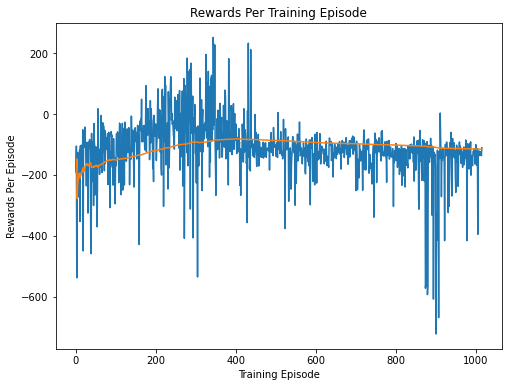

In [5]:
import matplotlib.pyplot as plt

#reward per training episode
episodes = range(len(train_rewards))
avg = []
for i in range(len(train_rewards)):
    avg.append(np.mean(train_rewards[0:i]))
    

plt.figure(figsize=[8,6])
plt.plot(episodes,train_rewards)
plt.plot(episodes,avg, label='Running Average')
plt.xlabel('Training Episode')
plt.ylabel('Rewards Per Episode')
plt.title('Rewards Per Training Episode')

plt.savefig('rewards_per_episode.png')


In [13]:
#save model if needed
torch.save(target_model.state_dict(), 'lunar_landing_model.pth')

In [14]:
#load model if needed
target_model = network(input_size, layer1_size, layer2_size, output_size)
target_model.load_state_dict(torch.load('lunar_landing_model.pth'))
target_model.eval()

network(
  (cnn): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

score:  -108.92984299385728
score:  -139.7517118594543
score:  -178.38585763819273
score:  -130.4145735541496
score:  -95.54670318778578
score:  -117.29456182673243
score:  -142.64056647521988
score:  -108.08865316177562
score:  -113.15533738757246
score:  -160.6598759464468
score:  -115.36443515125352
score:  -146.5383635922242
score:  -116.59354215217387
score:  -145.8474907785641
score:  -102.56779590977423
score:  -130.85346840237742
score:  -175.41253341048497
score:  -125.34150802456307
score:  -132.97918420603523
score:  -140.41469578854714
score:  -93.03158676992287
score:  -120.47067783384571
score:  -133.49258677417686
score:  -126.37968807568153
score:  -123.61439120830258
score:  -108.51131522552453
score:  -154.67044535012556
score:  -151.54909066592018
score:  -142.3167864200565
score:  -173.99573284865707
score:  -143.54275116727584
score:  -134.86269284303978
score:  -121.35105505805645
score:  -140.49447489289832
score:  -147.8326230388157
score:  -142.57368448274477
s

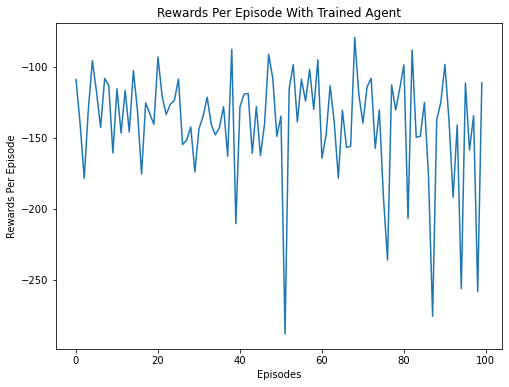

In [23]:
#Reward per episode for 100 consecutive episodes using you trained agent
episodes = range(100)

test_rewards = []
NN = Train()
NN.test(episodes,target_model,loss_fn,test_rewards)

plt.figure(figsize=[8,6])
plt.plot(episodes,test_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards Per Episode')
plt.title('Rewards Per Episode With Trained Agent')

plt.savefig('test_rewards_per_episode.png')